In [6]:
# General
import xarray as xr    # handles netcdf data
import numpy as np     # numerical functions etc
import pandas as pd    # dataframes
import matplotlib      # plotting functions
import matplotlib.pyplot as plt    # specific plotting function I use a lot   
from matplotlib.patches import Rectangle     # specific plotting function with an annoyingly long name
import matplotlib.gridspec as gridspec #to define the sizes of plots specifically
import geopandas as gpd    # shapefiles
import cartopy     # plotting geographical features
from shapely.geometry import MultiPolygon, Polygon #to deal with 3D polygons
import regionmask    # convert shapefile to binary 0,1 mask
import re     # regular expressions (replace substrings etc)
from geopy.geocoders import Nominatim    # get lat & lon coordinates from a place name

#for climate indices
import xclim.indices as xc_i
import xclim as xc

#For plotting
import matplotlib.ticker as plticker
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import nc_time_axis #to plot cf.time axis
import cftime #to plot cf.time axis

#For Statistics
import scipy.stats as stats
from scipy import optimize
from xclim.indices.stats import fit
from scipy.stats import norm, gamma
import lmoments3.distr                     # conda activate xclim; pip install git+https://github.com/OpenHydrology/lmoments3.git
glo = getattr(lmoments3.distr, "glo")

#For copulas
import sklarpy.univariate as sk_uni
from sklarpy.copulas import gh_copula
from sklarpy.multivariate import mvt_normal
from sklarpy.copulas import MarginalFitter
from sklarpy.univariate import UnivariateFitter
from sklarpy import print_full
from sklarpy.copulas import gumbel_copula
from sklarpy.copulas import frank_copula
from sklarpy.copulas import clayton_copula

#For handling errors
import sys
import warnings

## Necessary Functions:

In [7]:
def get_SPEI_Duration_and_Severity_RunTheory(spei,threshold_drought=-0.8,threshold_minor=-1.5,threshold_combining=1):
    '''
    Summary:
    -----------
    Function which calculates the Severity-Duration pairs for a given SPEI timeseries. 
    
    Parameters:
    -----------
    spei: xarray DataArray oject
            - Timeseries containing the spei values
            
    threshold_drought: float 
            - Threshold representing the onset of a drought event
         
    threshold_minor: float 
            - Threshold representing the minium spei value for a 1-month event to be considered a drought
    
    threshold_combining: float 
            - Threshold representing the minium spei value which needs to be exceeded that two drought events which
            are separated by only one month to be considered individual events
         
    Returns:
    ----------
    Duration: Array
            - Values representing the Duration of the Drought events      
        
    Severity: Array
            - Values representing the Severity of the Drought events   
    '''
    
    #Set-up Array
    duration=[]
    severity=[]
    
    D=0
    S=0
    for t in np.arange(0,len(spei),1):
        #Drought Condition
        if spei[t]<threshold_drought:
            D=D+1
            S=S+spei[t]
            
        #To take the case into account if last value is just one month -> ongoing heatwave, 
        #only when last severity is lower than threshold_combining and severity of event larger than threshold_minor!
        elif spei[t-1]<threshold_drought and t==len(spei)-1 and spei[t]<threshold_combining and spei[t] < threshold_minor:
            D=D+1
            S=S
            
        #The condition before corrected for the last loop
        elif t!=len(spei)-1 and spei[t-1]<threshold_drought and spei[t+1]<threshold_drought and spei[t]<threshold_combining:
            D=D+1
            S=S
        
        #If the spei value is above the threshold and none of the conditions above apply that drought event is over
        else:
            duration.append(D )
            D=0
            severity.append(S)
            S=0

    #to get values if the drought ends in the loop
    duration.append(D)
    severity.append(S)
    
    #remove all durations of 1 if Severity is less than threshold (here set to: -1.5) 
    for i in np.arange(0,len(duration),1):
        if duration[i] == 1:
            if severity[i] > threshold_minor:
                duration[i] = 0
                severity[i] = 0
                
    #Remove all 0 and define severity positive
    duration = np.array(duration)
    duration = duration[duration>0]
    
    severity = np.array(severity)
    severity = -severity
    severity = severity[severity>0]      
    
    return duration, severity

## Get CMIP6 Data

In [8]:
dir_data = '/rds/general/user/nmerz/home/MSc_Diss/data/AR6_regions/CMIP6/'

### Load Regions

In [9]:
fn_tmin = '/rds/general/user/nmerz/home/MSc_Diss/data/AR6_regions/obs/era5/model_data/era5_tmin_daily_275-330E_15--60N_su.nc'
ds_tmin = xr.open_dataset(fn_tmin).sel(time=slice("1950","2023"))
era5_tmin = ds_tmin.tmin

In [10]:
sf_all = gpd.read_file("/rds/general/user/nmerz/home/MSc_Diss/data/AR6_regions/shapefile").to_crs(cartopy.crs.PlateCarree())
sf_SA = sf_all[sf_all['Acronym'].str.contains("NWS|NSA|NES|SAM|SWS|SES|SSA")]
rm_SA = regionmask.mask_3D_geopandas(sf_SA, era5_tmin.lon, era5_tmin.lat).squeeze(drop = True)
sf_9 = sf_all[sf_all['Acronym'].str.contains("NWS")]
rm_9 = regionmask.mask_3D_geopandas(sf_9, era5_tmin.lon, era5_tmin.lat).squeeze(drop = True)
sf_10 = sf_all[sf_all['Acronym'].str.contains("NSA")]
rm_10 = regionmask.mask_3D_geopandas(sf_10, era5_tmin.lon, era5_tmin.lat).squeeze(drop = True)
sf_11 = sf_all[sf_all['Acronym'].str.contains("NES")]
rm_11 = regionmask.mask_3D_geopandas(sf_11, era5_tmin.lon, era5_tmin.lat).squeeze(drop = True)
sf_12 = sf_all[sf_all['Acronym'].str.contains("SAM")]
rm_12 = regionmask.mask_3D_geopandas(sf_12, era5_tmin.lon, era5_tmin.lat).squeeze(drop = True)
sf_13 = sf_all[sf_all['Acronym'].str.contains("SWS")]
rm_13 = regionmask.mask_3D_geopandas(sf_13, era5_tmin.lon, era5_tmin.lat).squeeze(drop = True)
sf_14 = sf_all[sf_all['Acronym'].str.contains("SES")]
rm_14 = regionmask.mask_3D_geopandas(sf_14, era5_tmin.lon, era5_tmin.lat).squeeze(drop = True)
sf_15 = sf_all[sf_all['Acronym'].str.contains("SSA")]
rm_15 = regionmask.mask_3D_geopandas(sf_15, era5_tmin.lon, era5_tmin.lat).squeeze(drop = True)

sf_shp_arr = np.array([sf_9,sf_10,sf_11,sf_12,sf_13,sf_14,sf_15])
region_shp_arr = np.array([rm_9,rm_10,rm_11,rm_12,rm_13,rm_14,rm_15])

## Load data


In [11]:
model_M1_arr = np.zeros((4,12,8))
model_M1 = model_M1_arr.tolist()

M_spei = 1

return_T_arr = ["10","50","100","500"]
for T in np.arange(0,4,1):
    for d in np.arange(1,13,1):
        T_str = return_T_arr[T]
        M_spei_str = str(M_spei)
        D_str = str(d)
        d_1 = d-1
        #ACCESS-CM2 #AccessCm2 
        model_name = "ACCESS-CM2/"
        fn_DA_AccessCm2 = dir_data + model_name + "results_sev_given_T_D/df_sev_M" + M_spei_str + "_T" + T_str + "_D" + D_str + "_final.csv"
        model_M1[T][d_1][0] = pd.read_csv(fn_DA_AccessCm2,sep=";",usecols=[1,2,3,4,5])

        #ACCESS-ESM1-5 #AccessEsm15 
        model_name = "ACCESS-ESM1-5/"
        fn_DA_AccessEsm15 = dir_data + model_name + "results_sev_given_T_D/df_sev_M" + M_spei_str + "_T" + T_str + "_D" + D_str + "_final.csv"
        model_M1[T][d_1][1] = pd.read_csv(fn_DA_AccessEsm15,sep=";",usecols=[1,2,3,4,5])

        #CanESM5 #CanEsm5
        model_name = "CanESM5/"
        fn_DA_CanEsm5 = dir_data + model_name + "results_sev_given_T_D/df_sev_M" + M_spei_str + "_T" + T_str + "_D" + D_str + "_final.csv"
        model_M1[T][d_1][2] = pd.read_csv(fn_DA_CanEsm5,sep=";",usecols=[1,2,3,4,5])

        #FGOALS-g3 #FgoalsG3
        model_name = "FGOALS-g3/"
        fn_DA_FgoalsG3 = dir_data + model_name + "results_sev_given_T_D/df_sev_M" + M_spei_str + "_T" + T_str + "_D" + D_str + "_final.csv"
        model_M1[T][d_1][3] = pd.read_csv(fn_DA_FgoalsG3,sep=";",usecols=[1,2,3,4,5])

        #IPSL-CM6A-LR #IpslCm6aLr
        model_name = "IPSL-CM6A-LR/"
        fn_DA_IpslCm6aLr = dir_data + model_name + "results_sev_given_T_D/df_sev_M" + M_spei_str + "_T" + T_str + "_D" + D_str + "_final.csv"
        model_M1[T][d_1][4] = pd.read_csv(fn_DA_IpslCm6aLr,sep=";",usecols=[1,2,3,4,5])

        #MIROC6 #Miroc6
        model_name = "MIROC6/"
        fn_DA_Miroc6 = dir_data + model_name + "results_sev_given_T_D/df_sev_M" + M_spei_str + "_T" + T_str + "_D" + D_str + "_final.csv"
        model_M1[T][d_1][5] = pd.read_csv(fn_DA_Miroc6,sep=";",usecols=[1,2,3,4,5])

        #MRI-ESM2-0 #MriEsm20
        model_name = "MRI-ESM2-0/"
        fn_DA_MriEsm20 = dir_data + model_name + "results_sev_given_T_D/df_sev_M" + M_spei_str + "_T" + T_str + "_D" + D_str + "_final.csv"
        model_M1[T][d_1][6] = pd.read_csv(fn_DA_MriEsm20,sep=";",usecols=[1,2,3,4,5])

        #NorESM2-LM #NorEsm2Lm
        model_name = "NorESM2-LM/"
        fn_DA_NorEsm2Lm = dir_data + model_name + "results_sev_given_T_D/df_sev_M" + M_spei_str + "_T" + T_str + "_D" + D_str + "_final.csv"
        model_M1[T][d_1][7] = pd.read_csv(fn_DA_NorEsm2Lm,sep=";",usecols=[1,2,3,4,5])

In [12]:
model_M6_arr = np.zeros((4,24,8))
model_M6 = model_M6_arr.tolist()

M_spei = 6

return_T_arr = ["10","50","100","500"]
for T in np.arange(0,4,1):
    for d in np.arange(1,25,1):
        T_str = return_T_arr[T]
        M_spei_str = str(M_spei)
        D_str = str(d)
        d_1 = d-1
        #ACCESS-CM2 #AccessCm2 
        model_name = "ACCESS-CM2/"
        fn_DA_AccessCm2 = dir_data + model_name + "results_sev_given_T_D/df_sev_M" + M_spei_str + "_T" + T_str + "_D" + D_str + "_final.csv"
        model_M6[T][d_1][0] = pd.read_csv(fn_DA_AccessCm2,sep=";",usecols=[1,2,3,4,5])

        #ACCESS-ESM1-5 #AccessEsm15 
        model_name = "ACCESS-ESM1-5/"
        fn_DA_AccessEsm15 = dir_data + model_name + "results_sev_given_T_D/df_sev_M" + M_spei_str + "_T" + T_str + "_D" + D_str + "_final.csv"
        model_M6[T][d_1][1] = pd.read_csv(fn_DA_AccessEsm15,sep=";",usecols=[1,2,3,4,5])

        #CanESM5 #CanEsm5
        model_name = "CanESM5/"
        fn_DA_CanEsm5 = dir_data + model_name + "results_sev_given_T_D/df_sev_M" + M_spei_str + "_T" + T_str + "_D" + D_str + "_final.csv"
        model_M6[T][d_1][2] = pd.read_csv(fn_DA_CanEsm5,sep=";",usecols=[1,2,3,4,5])

        #FGOALS-g3 #FgoalsG3
        model_name = "FGOALS-g3/"
        fn_DA_FgoalsG3 = dir_data + model_name + "results_sev_given_T_D/df_sev_M" + M_spei_str + "_T" + T_str + "_D" + D_str + "_final.csv"
        model_M6[T][d_1][3] = pd.read_csv(fn_DA_FgoalsG3,sep=";",usecols=[1,2,3,4,5])

        #IPSL-CM6A-LR #IpslCm6aLr
        model_name = "IPSL-CM6A-LR/"
        fn_DA_IpslCm6aLr = dir_data + model_name + "results_sev_given_T_D/df_sev_M" + M_spei_str + "_T" + T_str + "_D" + D_str + "_final.csv"
        model_M6[T][d_1][4] = pd.read_csv(fn_DA_IpslCm6aLr,sep=";",usecols=[1,2,3,4,5])

        #MIROC6 #Miroc6
        model_name = "MIROC6/"
        fn_DA_Miroc6 = dir_data + model_name + "results_sev_given_T_D/df_sev_M" + M_spei_str + "_T" + T_str + "_D" + D_str + "_final.csv"
        model_M6[T][d_1][5] = pd.read_csv(fn_DA_Miroc6,sep=";",usecols=[1,2,3,4,5])

        #MRI-ESM2-0 #MriEsm20
        model_name = "MRI-ESM2-0/"
        fn_DA_MriEsm20 = dir_data + model_name + "results_sev_given_T_D/df_sev_M" + M_spei_str + "_T" + T_str + "_D" + D_str + "_final.csv"
        model_M6[T][d_1][6] = pd.read_csv(fn_DA_MriEsm20,sep=";",usecols=[1,2,3,4,5])

        #NorESM2-LM #NorEsm2Lm
        model_name = "NorESM2-LM/"
        fn_DA_NorEsm2Lm = dir_data + model_name + "results_sev_given_T_D/df_sev_M" + M_spei_str + "_T" + T_str + "_D" + D_str + "_final.csv"
        model_M6[T][d_1][7] = pd.read_csv(fn_DA_NorEsm2Lm,sep=";",usecols=[1,2,3,4,5])

In [13]:
model_M12_arr = np.zeros((4,36,8))
model_M12 = model_M12_arr.tolist()

M_spei = 12

return_T_arr = ["10","50","100","500"]
for T in np.arange(0,4,1):
    for d in np.arange(1,37,1):
        T_str = return_T_arr[T]
        M_spei_str = str(M_spei)
        D_str = str(d)
        d_1 = d-1
        #ACCESS-CM2 #AccessCm2 
        model_name = "ACCESS-CM2/"
        fn_DA_AccessCm2 = dir_data + model_name + "results_sev_given_T_D/df_sev_M" + M_spei_str + "_T" + T_str + "_D" + D_str + "_final.csv"
        model_M12[T][d_1][0] = pd.read_csv(fn_DA_AccessCm2,sep=";",usecols=[1,2,3,4,5])

        #ACCESS-ESM1-5 #AccessEsm15 
        model_name = "ACCESS-ESM1-5/"
        fn_DA_AccessEsm15 = dir_data + model_name + "results_sev_given_T_D/df_sev_M" + M_spei_str + "_T" + T_str + "_D" + D_str + "_final.csv"
        model_M12[T][d_1][1] = pd.read_csv(fn_DA_AccessEsm15,sep=";",usecols=[1,2,3,4,5])

        #CanESM5 #CanEsm5
        model_name = "CanESM5/"
        fn_DA_CanEsm5 = dir_data + model_name + "results_sev_given_T_D/df_sev_M" + M_spei_str + "_T" + T_str + "_D" + D_str + "_final.csv"
        model_M12[T][d_1][2] = pd.read_csv(fn_DA_CanEsm5,sep=";",usecols=[1,2,3,4,5])

        #FGOALS-g3 #FgoalsG3
        model_name = "FGOALS-g3/"
        fn_DA_FgoalsG3 = dir_data + model_name + "results_sev_given_T_D/df_sev_M" + M_spei_str + "_T" + T_str + "_D" + D_str + "_final.csv"
        model_M12[T][d_1][3] = pd.read_csv(fn_DA_FgoalsG3,sep=";",usecols=[1,2,3,4,5])

        #IPSL-CM6A-LR #IpslCm6aLr
        model_name = "IPSL-CM6A-LR/"
        fn_DA_IpslCm6aLr = dir_data + model_name + "results_sev_given_T_D/df_sev_M" + M_spei_str + "_T" + T_str + "_D" + D_str + "_final.csv"
        model_M12[T][d_1][4] = pd.read_csv(fn_DA_IpslCm6aLr,sep=";",usecols=[1,2,3,4,5])

        #MIROC6 #Miroc6
        model_name = "MIROC6/"
        fn_DA_Miroc6 = dir_data + model_name + "results_sev_given_T_D/df_sev_M" + M_spei_str + "_T" + T_str + "_D" + D_str + "_final.csv"
        model_M12[T][d_1][5] = pd.read_csv(fn_DA_Miroc6,sep=";",usecols=[1,2,3,4,5])

        #MRI-ESM2-0 #MriEsm20
        model_name = "MRI-ESM2-0/"
        fn_DA_MriEsm20 = dir_data + model_name + "results_sev_given_T_D/df_sev_M" + M_spei_str + "_T" + T_str + "_D" + D_str + "_final.csv"
        model_M12[T][d_1][6] = pd.read_csv(fn_DA_MriEsm20,sep=";",usecols=[1,2,3,4,5])

        #NorESM2-LM #NorEsm2Lm
        model_name = "NorESM2-LM/"
        fn_DA_NorEsm2Lm = dir_data + model_name + "results_sev_given_T_D/df_sev_M" + M_spei_str + "_T" + T_str + "_D" + D_str + "_final.csv"
        model_M12[T][d_1][7] = pd.read_csv(fn_DA_NorEsm2Lm,sep=";",usecols=[1,2,3,4,5])

In [15]:
names_models = ['NWS','NSA','NES','SAM','SWS','SES','SSA',None]

## Plotting the data

### M1

In [17]:
#This selection is based on the model evaluation
M1_region_9_models=[None,None,2,3,4,5,6,7]
M1_region_10_models=[None,1,2,None,4,5,6,7]
M1_region_11_models=[0,1,None,None,None,5,6,7]
M1_region_12_models=[0,1,2,3,4,5,6,None]
M1_region_13_models=[0,1,2,3,4,5,6,7]
M1_region_14_models=[None,None,2,3,None,5,6,7]
M1_region_15_models=[0,1,2,3,4,5,6,7]

#Combine Results in Array
M1_region_models=[M1_region_9_models,M1_region_10_models,M1_region_11_models,M1_region_12_models,M1_region_13_models,M1_region_14_models,M1_region_15_models]

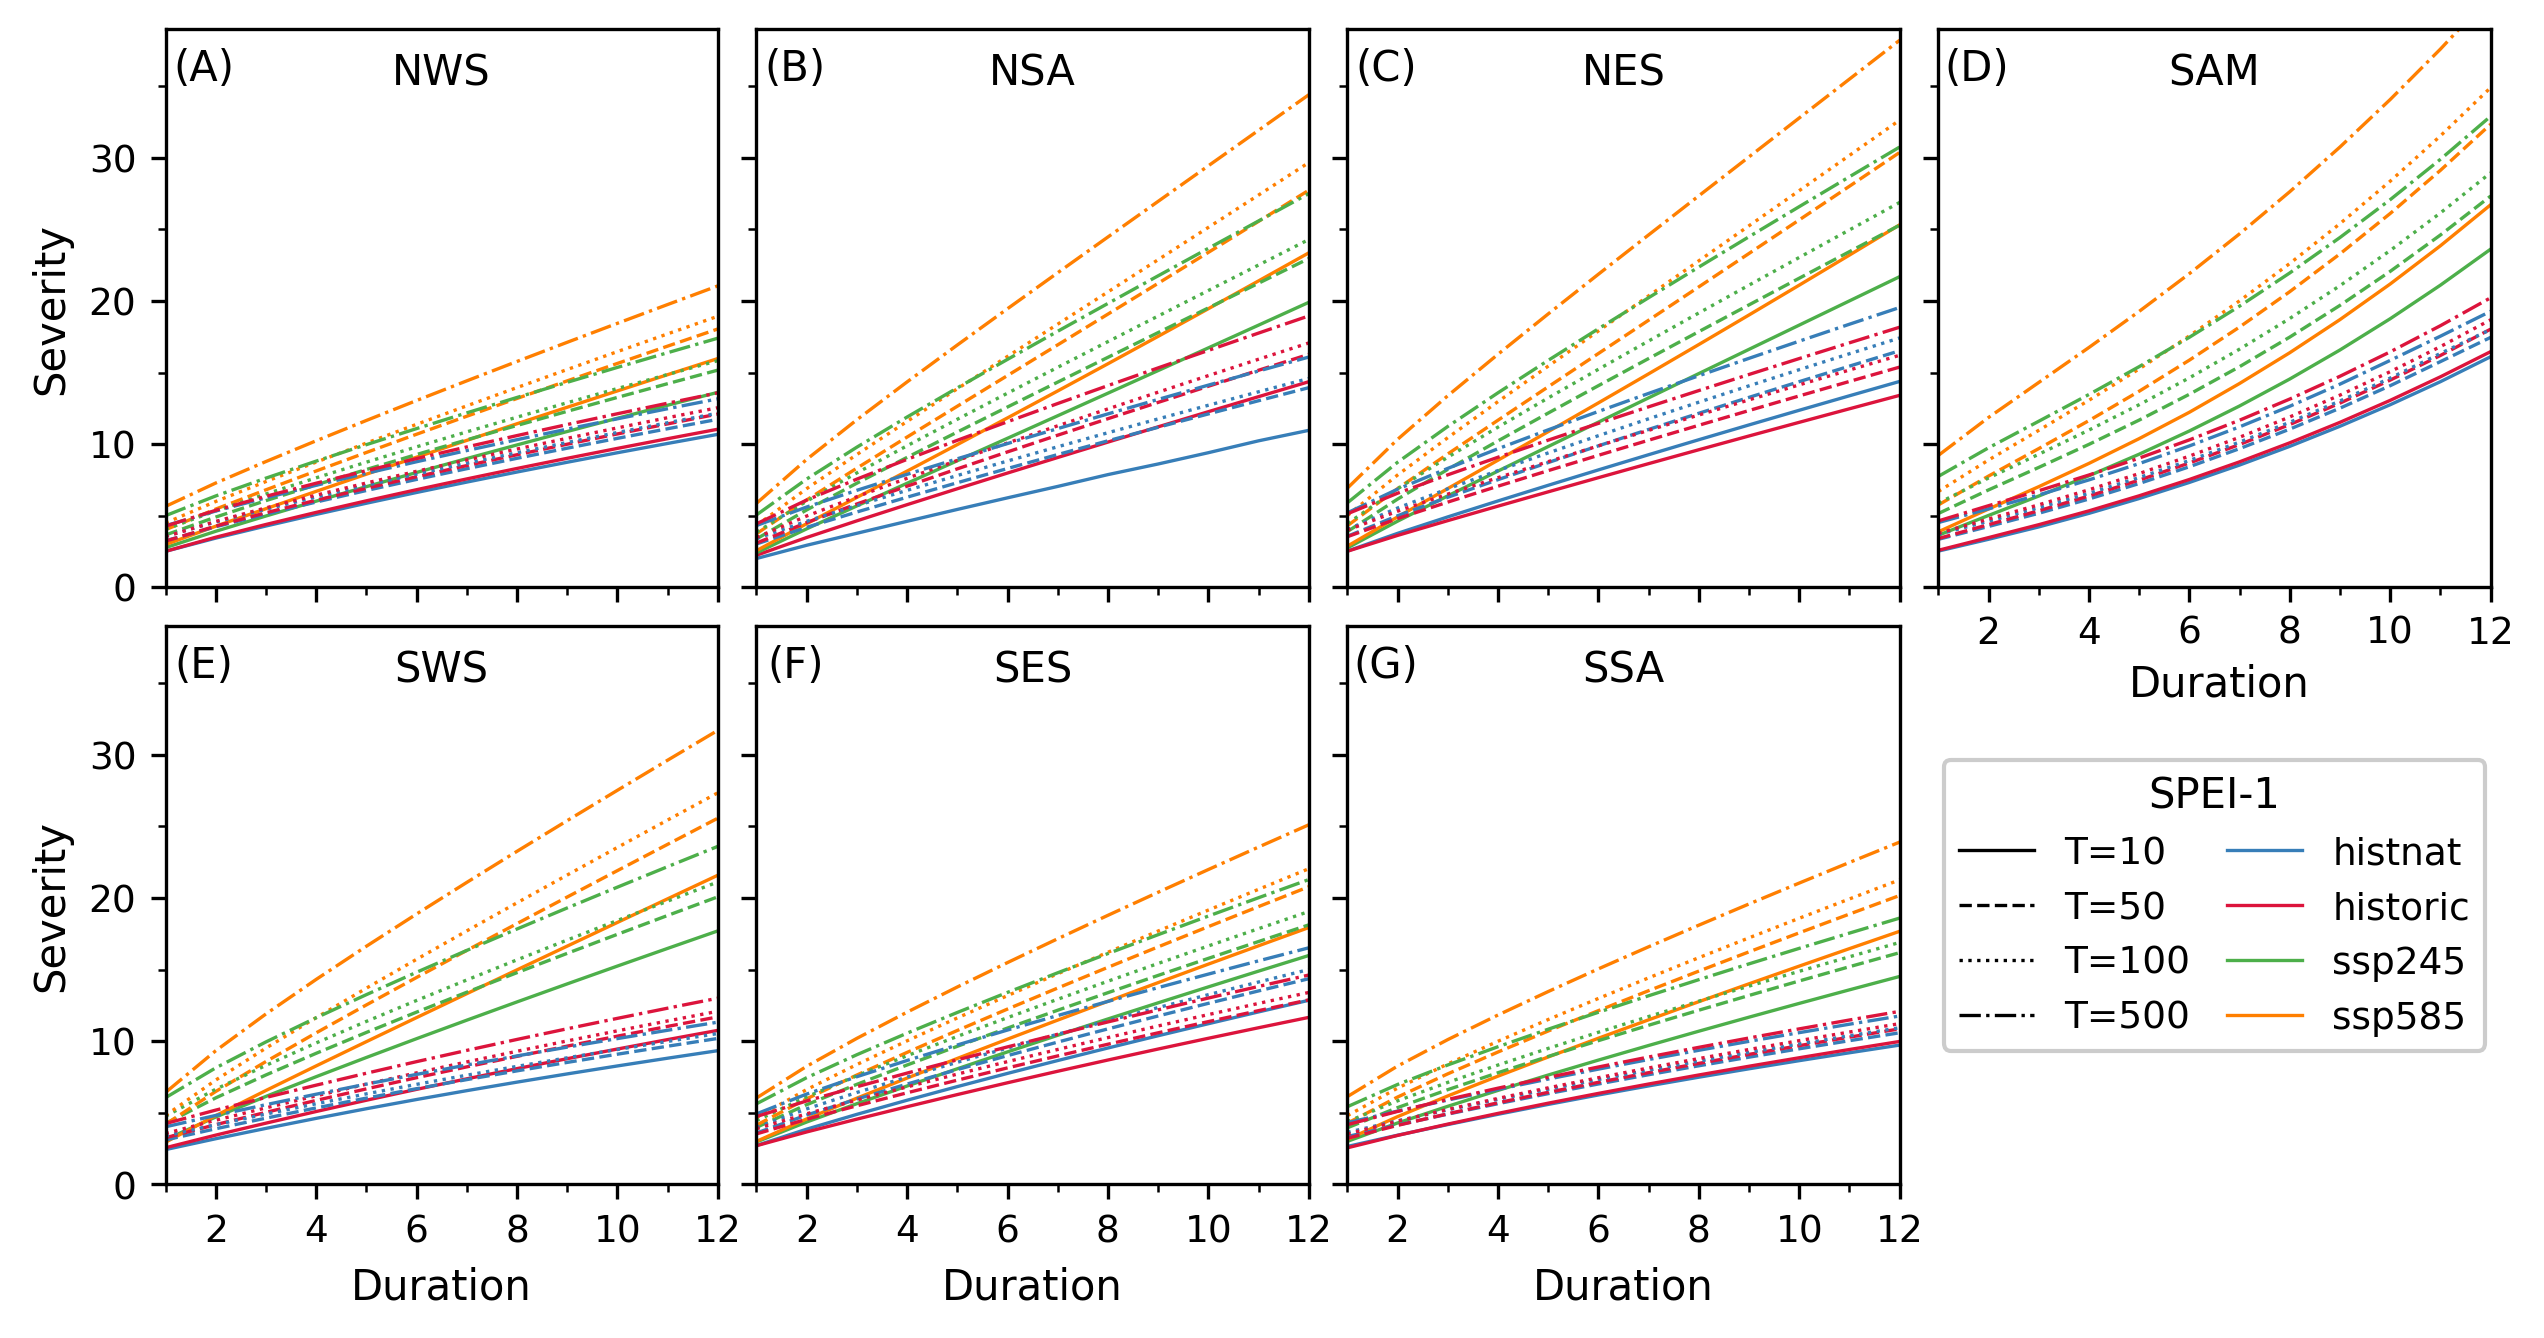

In [19]:
fig, ax = plt.subplots(ncols=4,nrows=2,figsize=(10,5),dpi = 300,sharey="row",sharex="col")
fig.subplots_adjust(hspace=0.07)
fig.subplots_adjust(wspace=0.07)
for s in np.arange(0,7,1):
    #Prepare empty arrays to store the data temporary for each region
    M1_T10_res_histnat_arr = []
    M1_T10_res_historic_arr = []
    M1_T10_res_ssp245_arr = []
    M1_T10_res_ssp585_arr = []
    
    M1_T50_res_histnat_arr = []
    M1_T50_res_historic_arr = []
    M1_T50_res_ssp245_arr = []
    M1_T50_res_ssp585_arr = []
        
    M1_T100_res_histnat_arr = []
    M1_T100_res_historic_arr = []
    M1_T100_res_ssp245_arr = []
    M1_T100_res_ssp585_arr = []
    
    M1_T500_res_histnat_arr = []
    M1_T500_res_historic_arr = []
    M1_T500_res_ssp245_arr = []
    M1_T500_res_ssp585_arr = []
    
    #Prepare empty arrays to store the data temporary for each month 
    for d in np.arange(0,12,1):
        D_str = str(d+1)
        region_eval = M1_region_models[s]
        #print(region_eval)
        M1_T10_val_histnat_arr = []
        M1_T10_val_historic_arr = []
        M1_T10_val_ssp245_arr = []
        M1_T10_val_ssp585_arr = []
        
        M1_T50_val_histnat_arr = []
        M1_T50_val_historic_arr = []
        M1_T50_val_ssp245_arr = []
        M1_T50_val_ssp585_arr = []
        
        M1_T100_val_histnat_arr = []
        M1_T100_val_historic_arr = []
        M1_T100_val_ssp245_arr = []
        M1_T100_val_ssp585_arr = []
        
        M1_T500_val_histnat_arr = []
        M1_T500_val_historic_arr = []
        M1_T500_val_ssp245_arr = []
        M1_T500_val_ssp585_arr = []
        
        #Loop over each of the 8 models
        for m in np.arange(0,8):
            #Only consider those models which passed the evaluation
            if region_eval[m] is not None:
                M1_T10_fn_histnat = "sev_M1_T10_D" + D_str + "_histnat"
                M1_T10_val_histnat_arr.append(model_M1[0][d][m][M1_T10_fn_histnat][s])
                M1_T10_fn_historic = "sev_M1_T10_D" + D_str + "_historic"
                M1_T10_val_historic_arr.append(model_M1[0][d][m][M1_T10_fn_historic][s])
                M1_T10_fn_ssp245 = "sev_M1_T10_D" + D_str + "_ssp245"
                M1_T10_val_ssp245_arr.append(model_M1[0][d][m][M1_T10_fn_ssp245][s])
                M1_T10_fn_ssp585 = "sev_M1_T10_D" + D_str + "_ssp585"
                M1_T10_val_ssp585_arr.append(model_M1[0][d][m][M1_T10_fn_ssp585][s])
                
                M1_T50_fn_histnat = "sev_M1_T50_D" + D_str + "_histnat"
                M1_T50_val_histnat_arr.append(model_M1[1][d][m][M1_T50_fn_histnat][s])
                M1_T50_fn_historic = "sev_M1_T50_D" + D_str + "_historic"
                M1_T50_val_historic_arr.append(model_M1[1][d][m][M1_T50_fn_historic][s])
                M1_T50_fn_ssp245 = "sev_M1_T50_D" + D_str + "_ssp245"
                M1_T50_val_ssp245_arr.append(model_M1[1][d][m][M1_T50_fn_ssp245][s])
                M1_T50_fn_ssp585 = "sev_M1_T50_D" + D_str + "_ssp585"
                M1_T50_val_ssp585_arr.append(model_M1[1][d][m][M1_T50_fn_ssp585][s])
                
                M1_T100_fn_histnat = "sev_M1_T100_D" + D_str + "_histnat"
                M1_T100_val_histnat_arr.append(model_M1[2][d][m][M1_T100_fn_histnat][s])
                M1_T100_fn_historic = "sev_M1_T100_D" + D_str + "_historic"
                M1_T100_val_historic_arr.append(model_M1[2][d][m][M1_T100_fn_historic][s])
                M1_T100_fn_ssp245 = "sev_M1_T100_D" + D_str + "_ssp245"
                M1_T100_val_ssp245_arr.append(model_M1[2][d][m][M1_T100_fn_ssp245][s])
                M1_T100_fn_ssp585 = "sev_M1_T100_D" + D_str + "_ssp585"
                M1_T100_val_ssp585_arr.append(model_M1[2][d][m][M1_T100_fn_ssp585][s])
                
                M1_T500_fn_histnat = "sev_M1_T500_D" + D_str + "_histnat"
                M1_T500_val_histnat_arr.append(model_M1[3][d][m][M1_T500_fn_histnat][s])
                M1_T500_fn_historic = "sev_M1_T500_D" + D_str + "_historic"
                M1_T500_val_historic_arr.append(model_M1[3][d][m][M1_T500_fn_historic][s])
                M1_T500_fn_ssp245 = "sev_M1_T500_D" + D_str + "_ssp245"
                M1_T500_val_ssp245_arr.append(model_M1[3][d][m][M1_T500_fn_ssp245][s])
                M1_T500_fn_ssp585 = "sev_M1_T500_D" + D_str + "_ssp585"
                M1_T500_val_ssp585_arr.append(model_M1[3][d][m][M1_T500_fn_ssp585][s])
        #print(len(M1_T500_val_histnat_arr))
        
        #Calcualte the mean of the different model severity results
        M1_T10_res_histnat_arr.append(np.array(M1_T10_val_histnat_arr).mean())
        M1_T10_res_historic_arr.append(np.array(M1_T10_val_historic_arr).mean())
        M1_T10_res_ssp245_arr.append(np.array(M1_T10_val_ssp245_arr).mean())
        M1_T10_res_ssp585_arr.append(np.array(M1_T10_val_ssp585_arr).mean())
        
        M1_T50_res_histnat_arr.append(np.array(M1_T50_val_histnat_arr).mean())
        M1_T50_res_historic_arr.append(np.array(M1_T50_val_historic_arr).mean())
        M1_T50_res_ssp245_arr.append(np.array(M1_T50_val_ssp245_arr).mean())
        M1_T50_res_ssp585_arr.append(np.array(M1_T50_val_ssp585_arr).mean())
        
        M1_T100_res_histnat_arr.append(np.array(M1_T100_val_histnat_arr).mean())
        M1_T100_res_historic_arr.append(np.array(M1_T100_val_historic_arr).mean())
        M1_T100_res_ssp245_arr.append(np.array(M1_T100_val_ssp245_arr).mean())
        M1_T100_res_ssp585_arr.append(np.array(M1_T100_val_ssp585_arr).mean())
        
        M1_T500_res_histnat_arr.append(np.array(M1_T500_val_histnat_arr).mean())
        M1_T500_res_historic_arr.append(np.array(M1_T500_val_historic_arr).mean())
        M1_T500_res_ssp245_arr.append(np.array(M1_T500_val_ssp245_arr).mean())
        M1_T500_res_ssp585_arr.append(np.array(M1_T500_val_ssp585_arr).mean())
    
    #Print the results      
    duration  =  np.arange(1,13,1)
    if s < 4:
        ax[0][s].plot(duration, M1_T10_res_histnat_arr,c='#377eb8',linewidth=0.8,label=r"T10: M1 histnat")
        ax[0][s].plot(duration, M1_T10_res_historic_arr,c='crimson',linewidth=0.8,label=r"T10: M1 historic")
        ax[0][s].plot(duration, M1_T10_res_ssp245_arr,c='#4daf4a',linewidth=0.8,label=r"T10: M1 ssp245")
        ax[0][s].plot(duration, M1_T10_res_ssp585_arr,c='#ff7f00',linewidth=0.8,label=r"T10: M1 ssp585")

        ax[0][s].plot(duration, M1_T50_res_histnat_arr,c='#377eb8',linewidth=0.8,label=r"T50: M1 histnat", ls="--")
        ax[0][s].plot(duration, M1_T50_res_historic_arr,c='crimson',linewidth=0.8,label=r"T50: M1 historic", ls="--")
        ax[0][s].plot(duration, M1_T50_res_ssp245_arr,c='#4daf4a',linewidth=0.8,label=r"T50: M1 ssp245", ls="--")
        ax[0][s].plot(duration, M1_T50_res_ssp585_arr,c='#ff7f00',linewidth=0.8,label=r"T50: M1 ssp585", ls="--")

        ax[0][s].plot(duration, M1_T100_res_histnat_arr,c='#377eb8',linewidth=0.8,label=r"T100: M1 histnat", ls=":")
        ax[0][s].plot(duration, M1_T100_res_historic_arr,c='crimson',linewidth=0.8,label=r"T100: M1 historic", ls=":")
        ax[0][s].plot(duration, M1_T100_res_ssp245_arr,c='#4daf4a',linewidth=0.8,label=r"T100: M1 ssp245", ls=":")
        ax[0][s].plot(duration, M1_T100_res_ssp585_arr,c='#ff7f00',linewidth=0.8,label=r"T100: M1 ssp585", ls=":")

        ax[0][s].plot(duration, M1_T500_res_histnat_arr,c='#377eb8',linewidth=0.8,label=r"T500: M1 histnat", ls="-.")
        ax[0][s].plot(duration, M1_T500_res_historic_arr,c='crimson',linewidth=0.8,label=r"T500: M1 historic", ls="-.")
        ax[0][s].plot(duration, M1_T500_res_ssp245_arr,c='#4daf4a',linewidth=0.8,label=r"T500: M1 ssp245", ls="-.")
        ax[0][s].plot(duration, M1_T500_res_ssp585_arr,c='#ff7f00',linewidth=0.8,label=r"T500: M1 ssp585", ls="-.")
    else:
        new_s = s-4
        ax[1][new_s].plot(duration, M1_T10_res_histnat_arr,c='#377eb8',linewidth=0.8)
        ax[1][new_s].plot(duration, M1_T10_res_historic_arr,c='crimson',linewidth=0.8)
        ax[1][new_s].plot(duration, M1_T10_res_ssp245_arr,c='#4daf4a',linewidth=0.8)
        ax[1][new_s].plot(duration, M1_T10_res_ssp585_arr,c='#ff7f00',linewidth=0.8)

        ax[1][new_s].plot(duration, M1_T50_res_histnat_arr,c='#377eb8',linewidth=0.8, ls="--")
        ax[1][new_s].plot(duration, M1_T50_res_historic_arr,c='crimson',linewidth=0.8, ls="--")
        ax[1][new_s].plot(duration, M1_T50_res_ssp245_arr,c='#4daf4a',linewidth=0.8, ls="--")
        ax[1][new_s].plot(duration, M1_T50_res_ssp585_arr,c='#ff7f00',linewidth=0.8, ls="--")

        ax[1][new_s].plot(duration, M1_T100_res_histnat_arr,c='#377eb8',linewidth=0.8, ls=":")
        ax[1][new_s].plot(duration, M1_T100_res_historic_arr,c='crimson',linewidth=0.8, ls=":")
        ax[1][new_s].plot(duration, M1_T100_res_ssp245_arr,c='#4daf4a',linewidth=0.8, ls=":")
        ax[1][new_s].plot(duration, M1_T100_res_ssp585_arr,c='#ff7f00',linewidth=0.8, ls=":")

        ax[1][new_s].plot(duration, M1_T500_res_histnat_arr,c='#377eb8',linewidth=0.8, ls="-.")
        ax[1][new_s].plot(duration, M1_T500_res_historic_arr,c='crimson',linewidth=0.8, ls="-.")
        ax[1][new_s].plot(duration, M1_T500_res_ssp245_arr,c='#4daf4a',linewidth=0.8, ls="-.")
        ax[1][new_s].plot(duration, M1_T500_res_ssp585_arr,c='#ff7f00',linewidth=0.8, ls="-.")

ax[1][0].set_xlabel(r'Duration',fontsize='10')
ax[1][1].set_xlabel(r'Duration',fontsize='10')
ax[1][2].set_xlabel(r'Duration',fontsize='10')
ax[0][0].set_ylabel(r'Severity',fontsize='10')
ax[1][0].set_ylabel(r'Severity',fontsize='10')

ticker_title = 0
for r in np.arange(0,2,1):
    for c in np.arange(0,4,1):
        ax[r][c].set_xlim(1,12)
        ax[r][c].set_ylim(0,39)
        ax[r][c].xaxis.set_major_locator(MultipleLocator(2))# defines setting of the small ticks
        ax[r][c].xaxis.set_minor_locator(MultipleLocator(1))# defines setting of the small ticks
        ax[r][c].yaxis.set_major_locator(MultipleLocator(10))# defines setting of the small ticks
        ax[r][c].yaxis.set_minor_locator(MultipleLocator(5))# defines setting of the small ticks
        ax[r][c].tick_params(axis='both', which='major', labelsize='9')
        #ax[r][c].grid(True,alpha=0.2,linestyle = 'dashed')

        ax[r][c].text(.5,.9,names_models[ticker_title],horizontalalignment='center',transform=ax[r][c].transAxes,fontsize='10')
        ticker_title += 1

# Manually add text for each duration value
duration_values = range(2, 13,2)  # Example duration values
for value in duration_values:
    ax[0,3].text(value, 0-0.05, str(value), va='top', ha='center', fontsize=9, transform=ax[0, 3].get_xaxis_transform())
ax[0][3].text(6.6, 0-0.135, "Duration", va='top', ha='center', fontsize=10, transform=ax[0, 3].get_xaxis_transform())

ax[1][2].plot(0,0,c='black',lw=0.8,label=r"T=10")
ax[1][2].plot(0,0,c='black',lw=0.8,ls="--",label=r"T=50")
ax[1][2].plot(0,0,c='black',lw=0.8,ls=":",label=r"T=100")
ax[1][2].plot(0,0,c='black',lw=0.8,ls="-.",label=r"T=500")
ax[1][2].plot(0,0,c='#377eb8',lw=0.8,label=r"histnat")
ax[1][2].plot(0,0,c='crimson',lw=0.8,label=r"historic")
ax[1][2].plot(0,0,c='#4daf4a',lw=0.8,label=r"ssp245")
ax[1][2].plot(0,0,c='#ff7f00',lw=0.8,label=r"ssp585")
legend = ax[1][2].legend(ncol=2,bbox_to_anchor=(1.08, 0.5), loc="center left", borderaxespad=0,
                         fontsize='9',title='SPEI-1', columnspacing=1)
legend.get_frame().set_alpha(0.5)
legend.get_frame().set_alpha(None)
fig.delaxes(ax[1][3])
        
# Add subplot labels
labels = ['(A)', '(B)', '(C)', '(D)','(E)', '(F)', '(G)',None]
for i, axes in enumerate(ax.flat): 
        #print(i)
    axes.annotate(labels[i], xy=(0.07, 0.93), xycoords='axes fraction',
                    fontsize=10, ha='center', va='center')

### M6

In [20]:
#Selection based on the Evaluation
M6_region_9_models=[None,None,2,3,4,5,6,7]
M6_region_10_models=[None,1,2,None,4,5,6,7]
M6_region_11_models=[0,1,None,None,None,5,6,7]
M6_region_12_models=[0,1,2,3,4,5,6,None]
M6_region_13_models=[0,1,2,3,4,5,6,7]
M6_region_14_models=[None,None,2,3,None,5,6,7]
M6_region_15_models=[0,1,2,3,4,5,6,7]
M6_region_models=[M6_region_9_models,M6_region_10_models,M6_region_11_models,M6_region_12_models,M6_region_13_models,M6_region_14_models,M6_region_15_models]

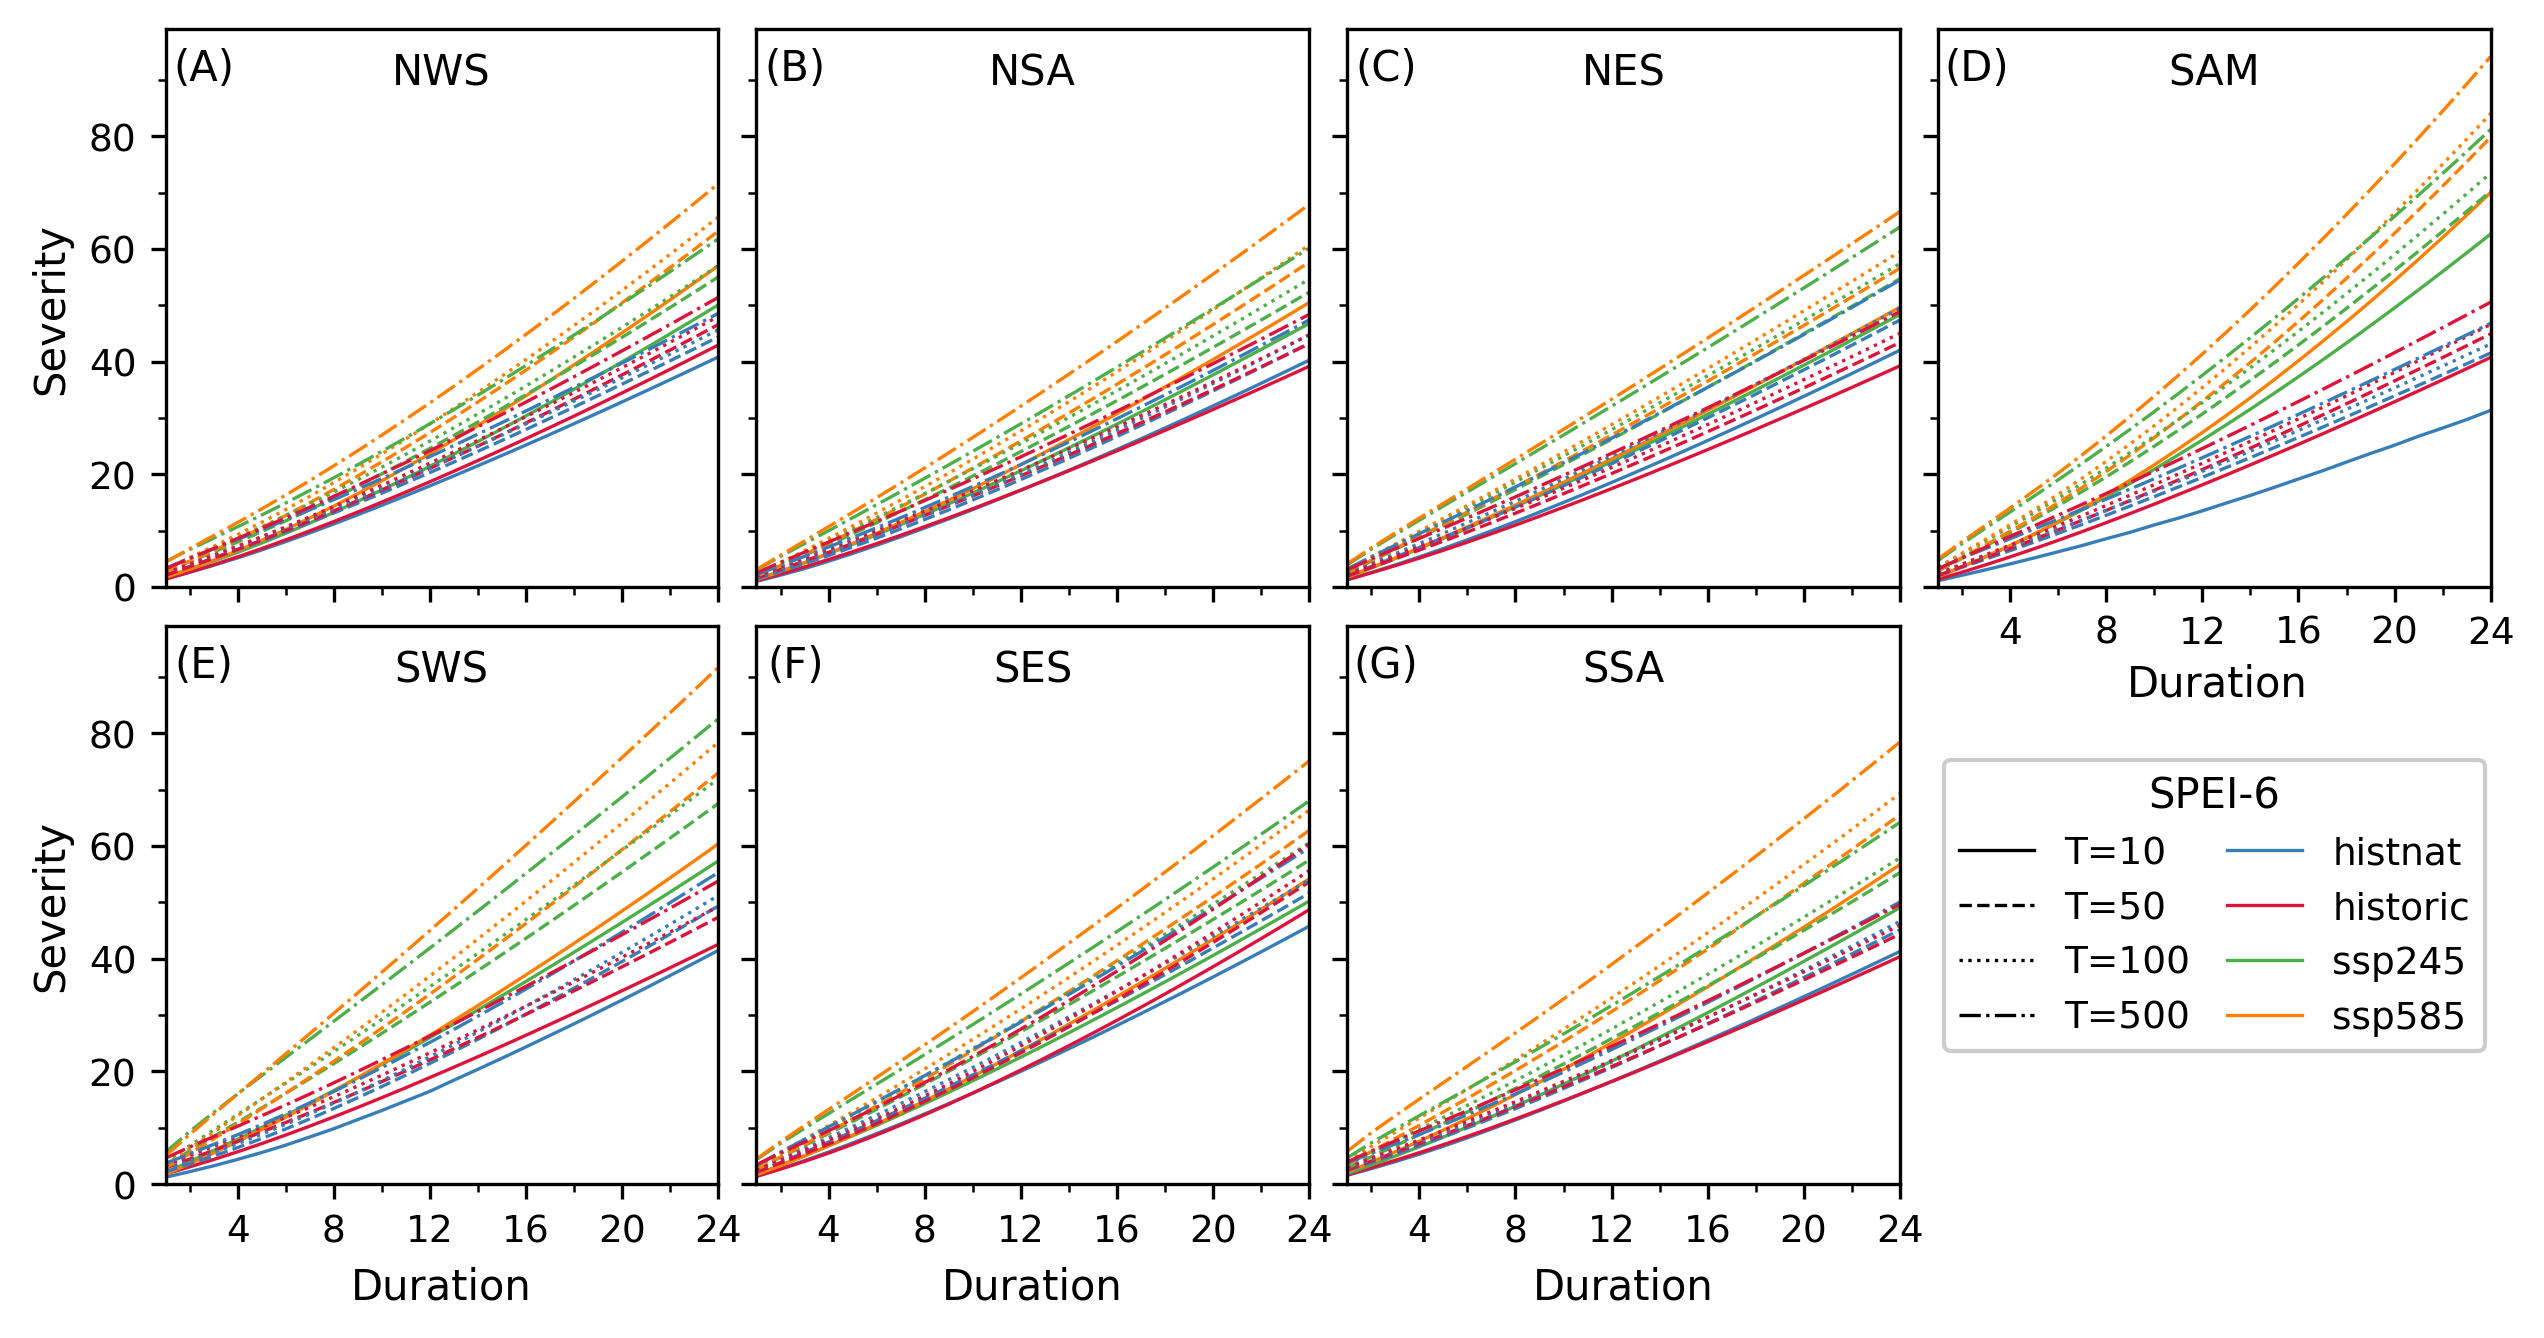

In [21]:
fig, ax = plt.subplots(ncols=4,nrows=2,figsize=(10,5),dpi = 300,sharey="row",sharex="col")
fig.subplots_adjust(hspace=0.07)
fig.subplots_adjust(wspace=0.07)
for s in np.arange(0,7,1):
    M6_T10_res_histnat_arr = []
    M6_T10_res_historic_arr = []
    M6_T10_res_ssp245_arr = []
    M6_T10_res_ssp585_arr = []
    
    M6_T50_res_histnat_arr = []
    M6_T50_res_historic_arr = []
    M6_T50_res_ssp245_arr = []
    M6_T50_res_ssp585_arr = []
        
    M6_T100_res_histnat_arr = []
    M6_T100_res_historic_arr = []
    M6_T100_res_ssp245_arr = []
    M6_T100_res_ssp585_arr = []
    
    M6_T500_res_histnat_arr = []
    M6_T500_res_historic_arr = []
    M6_T500_res_ssp245_arr = []
    M6_T500_res_ssp585_arr = []
    for d in np.arange(0,24,1):
        D_str = str(d+1)
        region_eval = M6_region_models[s]

        M6_T10_val_histnat_arr = []
        M6_T10_val_historic_arr = []
        M6_T10_val_ssp245_arr = []
        M6_T10_val_ssp585_arr = []
        
        M6_T50_val_histnat_arr = []
        M6_T50_val_historic_arr = []
        M6_T50_val_ssp245_arr = []
        M6_T50_val_ssp585_arr = []
        
        M6_T100_val_histnat_arr = []
        M6_T100_val_historic_arr = []
        M6_T100_val_ssp245_arr = []
        M6_T100_val_ssp585_arr = []
        
        M6_T500_val_histnat_arr = []
        M6_T500_val_historic_arr = []
        M6_T500_val_ssp245_arr = []
        M6_T500_val_ssp585_arr = []
        for m in np.arange(0,8):
            if region_eval[m] is not None:
                M6_T10_fn_histnat = "sev_M6_T10_D" + D_str + "_histnat"
                M6_T10_val_histnat_arr.append(model_M6[0][d][m][M6_T10_fn_histnat][s])
                M6_T10_fn_historic = "sev_M6_T10_D" + D_str + "_historic"
                M6_T10_val_historic_arr.append(model_M6[0][d][m][M6_T10_fn_historic][s])
                M6_T10_fn_ssp245 = "sev_M6_T10_D" + D_str + "_ssp245"
                M6_T10_val_ssp245_arr.append(model_M6[0][d][m][M6_T10_fn_ssp245][s])
                M6_T10_fn_ssp585 = "sev_M6_T10_D" + D_str + "_ssp585"
                M6_T10_val_ssp585_arr.append(model_M6[0][d][m][M6_T10_fn_ssp585][s])
                
                M6_T50_fn_histnat = "sev_M6_T50_D" + D_str + "_histnat"
                M6_T50_val_histnat_arr.append(model_M6[1][d][m][M6_T50_fn_histnat][s])
                M6_T50_fn_historic = "sev_M6_T50_D" + D_str + "_historic"
                M6_T50_val_historic_arr.append(model_M6[1][d][m][M6_T50_fn_historic][s])
                M6_T50_fn_ssp245 = "sev_M6_T50_D" + D_str + "_ssp245"
                M6_T50_val_ssp245_arr.append(model_M6[1][d][m][M6_T50_fn_ssp245][s])
                M6_T50_fn_ssp585 = "sev_M6_T50_D" + D_str + "_ssp585"
                M6_T50_val_ssp585_arr.append(model_M6[1][d][m][M6_T50_fn_ssp585][s])
                
                M6_T100_fn_histnat = "sev_M6_T100_D" + D_str + "_histnat"
                M6_T100_val_histnat_arr.append(model_M6[2][d][m][M6_T100_fn_histnat][s])
                M6_T100_fn_historic = "sev_M6_T100_D" + D_str + "_historic"
                M6_T100_val_historic_arr.append(model_M6[2][d][m][M6_T100_fn_historic][s])
                M6_T100_fn_ssp245 = "sev_M6_T100_D" + D_str + "_ssp245"
                M6_T100_val_ssp245_arr.append(model_M6[2][d][m][M6_T100_fn_ssp245][s])
                M6_T100_fn_ssp585 = "sev_M6_T100_D" + D_str + "_ssp585"
                M6_T100_val_ssp585_arr.append(model_M6[2][d][m][M6_T100_fn_ssp585][s])
                
                M6_T500_fn_histnat = "sev_M6_T500_D" + D_str + "_histnat"
                M6_T500_val_histnat_arr.append(model_M6[3][d][m][M6_T500_fn_histnat][s])
                M6_T500_fn_historic = "sev_M6_T500_D" + D_str + "_historic"
                M6_T500_val_historic_arr.append(model_M6[3][d][m][M6_T500_fn_historic][s])
                M6_T500_fn_ssp245 = "sev_M6_T500_D" + D_str + "_ssp245"
                M6_T500_val_ssp245_arr.append(model_M6[3][d][m][M6_T500_fn_ssp245][s])
                M6_T500_fn_ssp585 = "sev_M6_T500_D" + D_str + "_ssp585"
                M6_T500_val_ssp585_arr.append(model_M6[3][d][m][M6_T500_fn_ssp585][s])
        #print(len(M1_T500_val_histnat_arr))
        M6_T10_res_histnat_arr.append(np.array(M6_T10_val_histnat_arr).mean())
        M6_T10_res_historic_arr.append(np.array(M6_T10_val_historic_arr).mean())
        M6_T10_res_ssp245_arr.append(np.array(M6_T10_val_ssp245_arr).mean())
        M6_T10_res_ssp585_arr.append(np.array(M6_T10_val_ssp585_arr).mean())
        
        M6_T50_res_histnat_arr.append(np.array(M6_T50_val_histnat_arr).mean())
        M6_T50_res_historic_arr.append(np.array(M6_T50_val_historic_arr).mean())
        M6_T50_res_ssp245_arr.append(np.array(M6_T50_val_ssp245_arr).mean())
        M6_T50_res_ssp585_arr.append(np.array(M6_T50_val_ssp585_arr).mean())
        
        M6_T100_res_histnat_arr.append(np.array(M6_T100_val_histnat_arr).mean())
        M6_T100_res_historic_arr.append(np.array(M6_T100_val_historic_arr).mean())
        M6_T100_res_ssp245_arr.append(np.array(M6_T100_val_ssp245_arr).mean())
        M6_T100_res_ssp585_arr.append(np.array(M6_T100_val_ssp585_arr).mean())

        M6_T500_res_histnat_arr.append(np.array(M6_T500_val_histnat_arr).mean())
        M6_T500_res_historic_arr.append(np.array(M6_T500_val_historic_arr).mean())
        M6_T500_res_ssp245_arr.append(np.array(M6_T500_val_ssp245_arr).mean())
        M6_T500_res_ssp585_arr.append(np.array(M6_T500_val_ssp585_arr).mean())
        
    duration  =  np.arange(1,25,1)
    if s < 4:
        ax[0][s].plot(duration, M6_T10_res_histnat_arr,c='#377eb8',linewidth=0.8,label=r"T10: M6 histnat")
        ax[0][s].plot(duration, M6_T10_res_historic_arr,c='crimson',linewidth=0.8,label=r"T10: M6 historic")
        ax[0][s].plot(duration, M6_T10_res_ssp245_arr,c='#4daf4a',linewidth=0.8,label=r"T10: M6 ssp245")
        ax[0][s].plot(duration, M6_T10_res_ssp585_arr,c='#ff7f00',linewidth=0.8,label=r"T10: M6 ssp585")

        ax[0][s].plot(duration, M6_T50_res_histnat_arr,c='#377eb8',linewidth=0.8,label=r"T50: M6 histnat", ls="--")
        ax[0][s].plot(duration, M6_T50_res_historic_arr,c='crimson',linewidth=0.8,label=r"T50: M6 historic", ls="--")
        ax[0][s].plot(duration, M6_T50_res_ssp245_arr,c='#4daf4a',linewidth=0.8,label=r"T50: M6 ssp245", ls="--")
        ax[0][s].plot(duration, M6_T50_res_ssp585_arr,c='#ff7f00',linewidth=0.8,label=r"T50: M6 ssp585", ls="--")

        ax[0][s].plot(duration, M6_T100_res_histnat_arr,c='#377eb8',linewidth=0.8,label=r"T100: M6 histnat", ls=":")
        ax[0][s].plot(duration, M6_T100_res_historic_arr,c='crimson',linewidth=0.8,label=r"T100: M6 historic", ls=":")
        ax[0][s].plot(duration, M6_T100_res_ssp245_arr,c='#4daf4a',linewidth=0.8,label=r"T100: M6 ssp245", ls=":")
        ax[0][s].plot(duration, M6_T100_res_ssp585_arr,c='#ff7f00',linewidth=0.8,label=r"T100: M6 ssp585", ls=":")

        ax[0][s].plot(duration, M6_T500_res_histnat_arr,c='#377eb8',linewidth=0.8,label=r"T500: M6 histnat", ls="-.")
        ax[0][s].plot(duration, M6_T500_res_historic_arr,c='crimson',linewidth=0.8,label=r"T500: M6 historic", ls="-.")
        ax[0][s].plot(duration, M6_T500_res_ssp245_arr,c='#4daf4a',linewidth=0.8,label=r"T500: M6 ssp245", ls="-.")
        ax[0][s].plot(duration, M6_T500_res_ssp585_arr,c='#ff7f00',linewidth=0.8,label=r"T500: M6 ssp585", ls="-.")
    else:
        new_s = s-4
        ax[1][new_s].plot(duration, M6_T10_res_histnat_arr,c='#377eb8',linewidth=0.8)
        ax[1][new_s].plot(duration, M6_T10_res_historic_arr,c='crimson',linewidth=0.8)
        ax[1][new_s].plot(duration, M6_T10_res_ssp245_arr,c='#4daf4a',linewidth=0.8)
        ax[1][new_s].plot(duration, M6_T10_res_ssp585_arr,c='#ff7f00',linewidth=0.8)

        ax[1][new_s].plot(duration, M6_T50_res_histnat_arr,c='#377eb8',linewidth=0.8, ls="--")
        ax[1][new_s].plot(duration, M6_T50_res_historic_arr,c='crimson',linewidth=0.8, ls="--")
        ax[1][new_s].plot(duration, M6_T50_res_ssp245_arr,c='#4daf4a',linewidth=0.8, ls="--")
        ax[1][new_s].plot(duration, M6_T50_res_ssp585_arr,c='#ff7f00',linewidth=0.8, ls="--")

        ax[1][new_s].plot(duration, M6_T100_res_histnat_arr,c='#377eb8',linewidth=0.8, ls=":")
        ax[1][new_s].plot(duration, M6_T100_res_historic_arr,c='crimson',linewidth=0.8, ls=":")
        ax[1][new_s].plot(duration, M6_T100_res_ssp245_arr,c='#4daf4a',linewidth=0.8, ls=":")
        ax[1][new_s].plot(duration, M6_T100_res_ssp585_arr,c='#ff7f00',linewidth=0.8, ls=":")

        ax[1][new_s].plot(duration, M6_T500_res_histnat_arr,c='#377eb8',linewidth=0.8, ls="-.")
        ax[1][new_s].plot(duration, M6_T500_res_historic_arr,c='crimson',linewidth=0.8, ls="-.")
        ax[1][new_s].plot(duration, M6_T500_res_ssp245_arr,c='#4daf4a',linewidth=0.8, ls="-.")
        ax[1][new_s].plot(duration, M6_T500_res_ssp585_arr,c='#ff7f00',linewidth=0.8, ls="-.")

ax[1][0].set_xlabel(r'Duration',fontsize='10')
ax[1][1].set_xlabel(r'Duration',fontsize='10')
ax[1][2].set_xlabel(r'Duration',fontsize='10')
ax[1][3].set_xlabel(r'Duration',fontsize='10')
ax[0][0].set_ylabel(r'Severity',fontsize='10')
ax[1][0].set_ylabel(r'Severity',fontsize='10')

# Manually add text for each duration value
duration_values = range(4, 25,4)  # Example duration values
for value in duration_values:
    ax[0,3].text(value, 0-0.05, str(value), va='top', ha='center', fontsize=9, transform=ax[0, 3].get_xaxis_transform())
ax[0][3].text(12.6, 0-0.135, "Duration", va='top', ha='center', fontsize=10, transform=ax[0, 3].get_xaxis_transform())

ticker_title = 0
for r in np.arange(0,2,1):
    for c in np.arange(0,4,1):
        ax[r][c].set_xlim(1,24)
        ax[r][c].set_ylim(0,99)
        ax[r][c].xaxis.set_major_locator(MultipleLocator(4))# defines setting of the small ticks
        ax[r][c].xaxis.set_minor_locator(MultipleLocator(2))# defines setting of the small ticks
        ax[r][c].yaxis.set_major_locator(MultipleLocator(20))# defines setting of the small ticks
        ax[r][c].yaxis.set_minor_locator(MultipleLocator(10))# defines setting of the small ticks
        ax[r][c].tick_params(axis='both', which='major', labelsize='9')
        #ax[r][c].grid(True,alpha=0.2,linestyle = 'dashed')

        ax[r][c].text(.5,.9,names_models[ticker_title],horizontalalignment='center',transform=ax[r][c].transAxes,fontsize='10')
        ticker_title += 1

ax[1][2].plot(0,0,c='black',lw=0.8,label=r"T=10")
ax[1][2].plot(0,0,c='black',lw=0.8,ls="--",label=r"T=50")
ax[1][2].plot(0,0,c='black',lw=0.8,ls=":",label=r"T=100")
ax[1][2].plot(0,0,c='black',lw=0.8,ls="-.",label=r"T=500")
ax[1][2].plot(0,0,c='#377eb8',lw=0.8,label=r"histnat")
ax[1][2].plot(0,0,c='crimson',lw=0.8,label=r"historic")
ax[1][2].plot(0,0,c='#4daf4a',lw=0.8,label=r"ssp245")
ax[1][2].plot(0,0,c='#ff7f00',lw=0.8,label=r"ssp585")
legend = ax[1][2].legend(ncol=2,bbox_to_anchor=(1.08, 0.5), loc="center left", borderaxespad=0,
                         fontsize='9',title='SPEI-6', columnspacing=1)
legend.get_frame().set_alpha(0.5)
legend.get_frame().set_alpha(None)
fig.delaxes(ax[1][3])
        
# Add subplot labels
labels = ['(A)', '(B)', '(C)', '(D)','(E)', '(F)', '(G)',None]
for i, axes in enumerate(ax.flat): 
        #print(i)
    axes.annotate(labels[i], xy=(0.07, 0.93), xycoords='axes fraction',
                    fontsize=10, ha='center', va='center')

### M12

In [23]:
M12_region_9_models=[None,None,2,3,4,5,6,7]
M12_region_10_models=[None,1,None,None,4,5,6,7]
M12_region_11_models=[0,1,None,None,None,5,6,7]
M12_region_12_models=[0,1,2,3,4,5,6,None]
M12_region_13_models=[0,1,2,3,None,5,6,7]
M12_region_14_models=[None,None,2,3,None,5,6,7]
#M12_region_15_models=[0,1,2,3,4,5,6,7]
M12_region_15_models=[0,1,2,None,None,5,None,7]
M12_region_models=[M12_region_9_models,M12_region_10_models,M12_region_11_models,M12_region_12_models,M12_region_13_models,M12_region_14_models,M12_region_15_models]

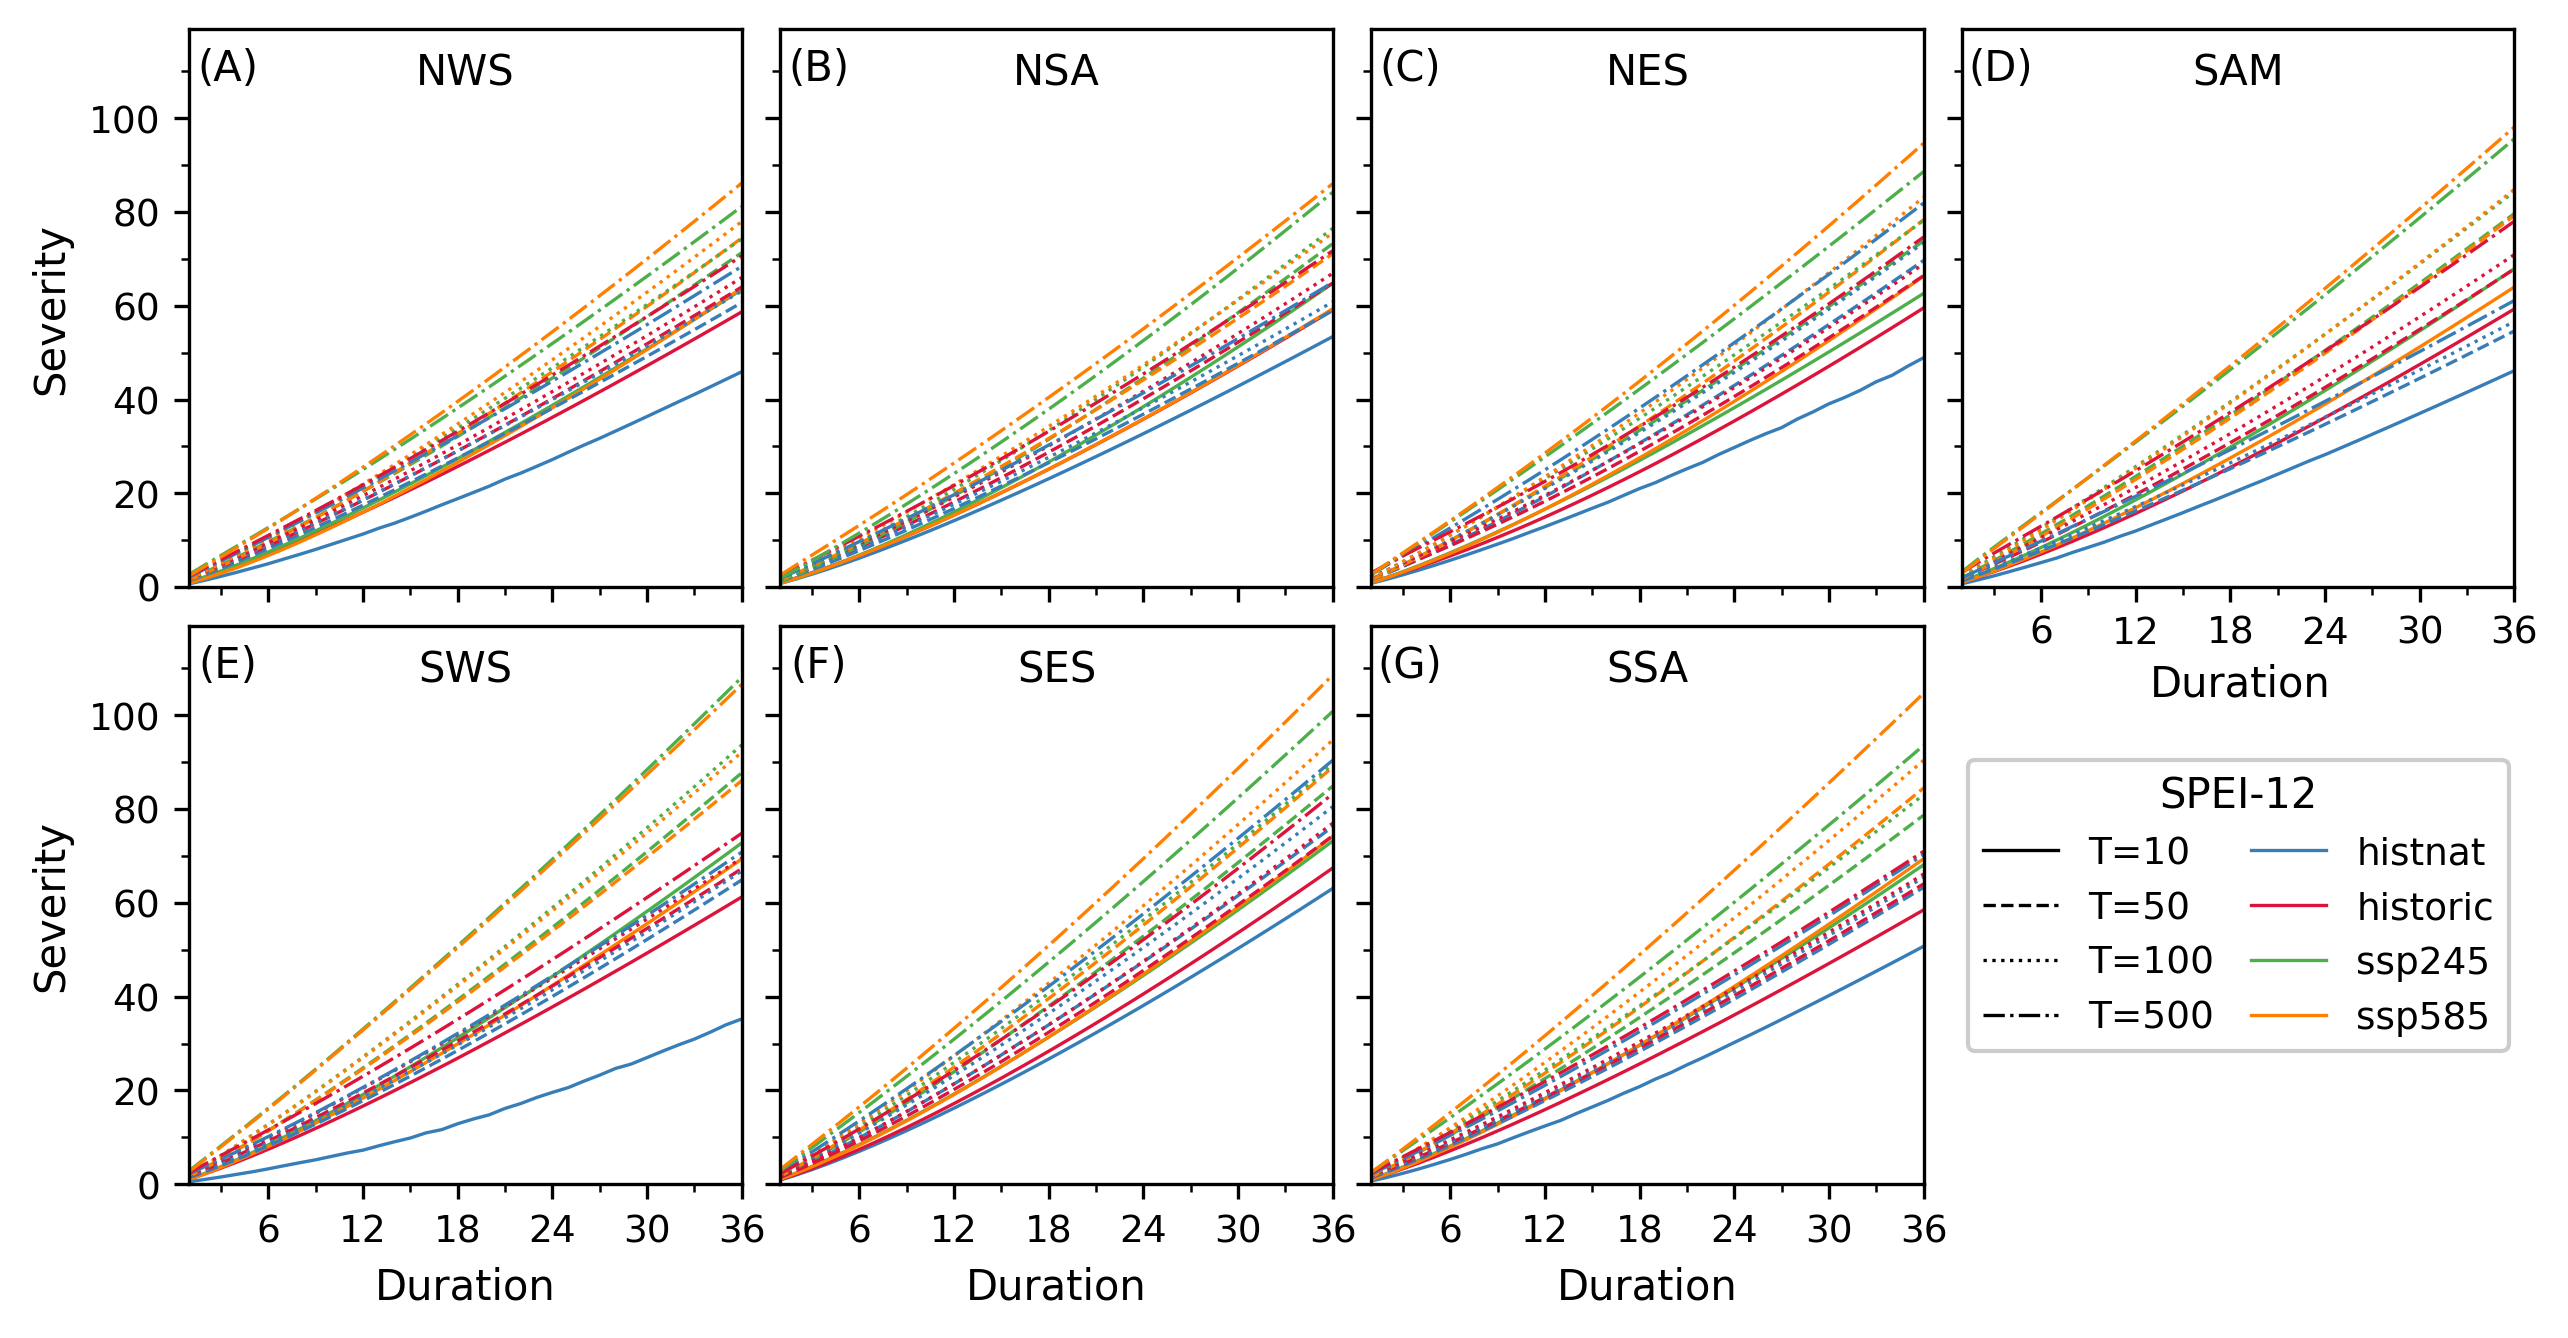

In [24]:
fig, ax = plt.subplots(ncols=4,nrows=2,figsize=(10,5),dpi = 300,sharey="row",sharex="col")
fig.subplots_adjust(hspace=0.07)
fig.subplots_adjust(wspace=0.07)
for s in np.arange(0,7,1):
    M12_T10_res_histnat_arr = []
    M12_T10_res_historic_arr = []
    M12_T10_res_ssp245_arr = []
    M12_T10_res_ssp585_arr = []
    
    M12_T50_res_histnat_arr = []
    M12_T50_res_historic_arr = []
    M12_T50_res_ssp245_arr = []
    M12_T50_res_ssp585_arr = []
        
    M12_T100_res_histnat_arr = []
    M12_T100_res_historic_arr = []
    M12_T100_res_ssp245_arr = []
    M12_T100_res_ssp585_arr = []
    
    M12_T500_res_histnat_arr = []
    M12_T500_res_historic_arr = []
    M12_T500_res_ssp245_arr = []
    M12_T500_res_ssp585_arr = []
    for d in np.arange(0,36,1):
        D_str = str(d+1)
        region_eval = M12_region_models[s]
        #print(region_eval)
        M12_T10_val_histnat_arr = []
        M12_T10_val_historic_arr = []
        M12_T10_val_ssp245_arr = []
        M12_T10_val_ssp585_arr = []
        
        M12_T50_val_histnat_arr = []
        M12_T50_val_historic_arr = []
        M12_T50_val_ssp245_arr = []
        M12_T50_val_ssp585_arr = []
        
        M12_T100_val_histnat_arr = []
        M12_T100_val_historic_arr = []
        M12_T100_val_ssp245_arr = []
        M12_T100_val_ssp585_arr = []
        
        M12_T500_val_histnat_arr = []
        M12_T500_val_historic_arr = []
        M12_T500_val_ssp245_arr = []
        M12_T500_val_ssp585_arr = []
        for m in np.arange(0,8):
            if region_eval[m] is not None:
                M12_T10_fn_histnat = "sev_M12_T10_D" + D_str + "_histnat"
                M12_T10_val_histnat_arr.append(model_M12[0][d][m][M12_T10_fn_histnat][s])
                M12_T10_fn_historic = "sev_M12_T10_D" + D_str + "_historic"
                M12_T10_val_historic_arr.append(model_M12[0][d][m][M12_T10_fn_historic][s])
                M12_T10_fn_ssp245 = "sev_M12_T10_D" + D_str + "_ssp245"
                M12_T10_val_ssp245_arr.append(model_M12[0][d][m][M12_T10_fn_ssp245][s])
                M12_T10_fn_ssp585 = "sev_M12_T10_D" + D_str + "_ssp585"
                M12_T10_val_ssp585_arr.append(model_M12[0][d][m][M12_T10_fn_ssp585][s])
                
                M12_T50_fn_histnat = "sev_M12_T50_D" + D_str + "_histnat"
                M12_T50_val_histnat_arr.append(model_M12[1][d][m][M12_T50_fn_histnat][s])
                M12_T50_fn_historic = "sev_M12_T50_D" + D_str + "_historic"
                M12_T50_val_historic_arr.append(model_M12[1][d][m][M12_T50_fn_historic][s])
                M12_T50_fn_ssp245 = "sev_M12_T50_D" + D_str + "_ssp245"
                M12_T50_val_ssp245_arr.append(model_M12[1][d][m][M12_T50_fn_ssp245][s])
                M12_T50_fn_ssp585 = "sev_M12_T50_D" + D_str + "_ssp585"
                M12_T50_val_ssp585_arr.append(model_M12[1][d][m][M12_T50_fn_ssp585][s])
                
                M12_T100_fn_histnat = "sev_M12_T100_D" + D_str + "_histnat"
                M12_T100_val_histnat_arr.append(model_M12[2][d][m][M12_T100_fn_histnat][s])
                M12_T100_fn_historic = "sev_M12_T100_D" + D_str + "_historic"
                M12_T100_val_historic_arr.append(model_M12[2][d][m][M12_T100_fn_historic][s])
                M12_T100_fn_ssp245 = "sev_M12_T100_D" + D_str + "_ssp245"
                M12_T100_val_ssp245_arr.append(model_M12[2][d][m][M12_T100_fn_ssp245][s])
                M12_T100_fn_ssp585 = "sev_M12_T100_D" + D_str + "_ssp585"
                M12_T100_val_ssp585_arr.append(model_M12[2][d][m][M12_T100_fn_ssp585][s])
                
                M12_T500_fn_histnat = "sev_M12_T500_D" + D_str + "_histnat"
                M12_T500_val_histnat_arr.append(model_M12[3][d][m][M12_T500_fn_histnat][s])
                M12_T500_fn_historic = "sev_M12_T500_D" + D_str + "_historic"
                M12_T500_val_historic_arr.append(model_M12[3][d][m][M12_T500_fn_historic][s])
                M12_T500_fn_ssp245 = "sev_M12_T500_D" + D_str + "_ssp245"
                M12_T500_val_ssp245_arr.append(model_M12[3][d][m][M12_T500_fn_ssp245][s])
                M12_T500_fn_ssp585 = "sev_M12_T500_D" + D_str + "_ssp585"
                M12_T500_val_ssp585_arr.append(model_M12[3][d][m][M12_T500_fn_ssp585][s])
        #print(len(M1_T500_val_histnat_arr))
        M12_T10_res_histnat_arr.append(np.array(M12_T10_val_histnat_arr).mean())
        M12_T10_res_historic_arr.append(np.array(M12_T10_val_historic_arr).mean())
        M12_T10_res_ssp245_arr.append(np.array(M12_T10_val_ssp245_arr).mean())
        M12_T10_res_ssp585_arr.append(np.array(M12_T10_val_ssp585_arr).mean())
        
        M12_T50_res_histnat_arr.append(np.array(M12_T50_val_histnat_arr).mean())
        M12_T50_res_historic_arr.append(np.array(M12_T50_val_historic_arr).mean())
        M12_T50_res_ssp245_arr.append(np.array(M12_T50_val_ssp245_arr).mean())
        M12_T50_res_ssp585_arr.append(np.array(M12_T50_val_ssp585_arr).mean())
        
        M12_T100_res_histnat_arr.append(np.array(M12_T100_val_histnat_arr).mean())
        M12_T100_res_historic_arr.append(np.array(M12_T100_val_historic_arr).mean())
        M12_T100_res_ssp245_arr.append(np.array(M12_T100_val_ssp245_arr).mean())
        M12_T100_res_ssp585_arr.append(np.array(M12_T100_val_ssp585_arr).mean())

        M12_T500_res_histnat_arr.append(np.array(M12_T500_val_histnat_arr).mean())
        M12_T500_res_historic_arr.append(np.array(M12_T500_val_historic_arr).mean())
        M12_T500_res_ssp245_arr.append(np.array(M12_T500_val_ssp245_arr).mean())
        M12_T500_res_ssp585_arr.append(np.array(M12_T500_val_ssp585_arr).mean())
        
    duration  =  np.arange(1,37,1)
    if s < 4:
        ax[0][s].plot(duration, M12_T10_res_histnat_arr,c='#377eb8',linewidth=0.8,label=r"T10: M12 histnat")
        ax[0][s].plot(duration, M12_T10_res_historic_arr,c='crimson',linewidth=0.8,label=r"T10: M12 historic")
        ax[0][s].plot(duration, M12_T10_res_ssp245_arr,c='#4daf4a',linewidth=0.8,label=r"T10: M12 ssp245")
        ax[0][s].plot(duration, M12_T10_res_ssp585_arr,c='#ff7f00',linewidth=0.8,label=r"T10: M12 ssp585")

        ax[0][s].plot(duration, M12_T50_res_histnat_arr,c='#377eb8',linewidth=0.8,label=r"T50: M12 histnat", ls="--")
        ax[0][s].plot(duration, M12_T50_res_historic_arr,c='crimson',linewidth=0.8,label=r"T50: M12 historic", ls="--")
        ax[0][s].plot(duration, M12_T50_res_ssp245_arr,c='#4daf4a',linewidth=0.8,label=r"T50: M12 ssp245", ls="--")
        ax[0][s].plot(duration, M12_T50_res_ssp585_arr,c='#ff7f00',linewidth=0.8,label=r"T50: M12 ssp585", ls="--")

        ax[0][s].plot(duration, M12_T100_res_histnat_arr,c='#377eb8',linewidth=0.8,label=r"T100: M12 histnat", ls=":")
        ax[0][s].plot(duration, M12_T100_res_historic_arr,c='crimson',linewidth=0.8,label=r"T100: M12 historic", ls=":")
        ax[0][s].plot(duration, M12_T100_res_ssp245_arr,c='#4daf4a',linewidth=0.8,label=r"T100: M12 ssp245", ls=":")
        ax[0][s].plot(duration, M12_T100_res_ssp585_arr,c='#ff7f00',linewidth=0.8,label=r"T100: M12 ssp585", ls=":")

        ax[0][s].plot(duration, M12_T500_res_histnat_arr,c='#377eb8',linewidth=0.8,label=r"T500: M12 histnat", ls="-.")
        ax[0][s].plot(duration, M12_T500_res_historic_arr,c='crimson',linewidth=0.8,label=r"T500: M12 historic", ls="-.")
        ax[0][s].plot(duration, M12_T500_res_ssp245_arr,c='#4daf4a',linewidth=0.8,label=r"T500: M12 ssp245", ls="-.")
        ax[0][s].plot(duration, M12_T500_res_ssp585_arr,c='#ff7f00',linewidth=0.8,label=r"T500: M12 ssp585", ls="-.")
    else:
        new_s = s-4
        ax[1][new_s].plot(duration, M12_T10_res_histnat_arr,c='#377eb8',linewidth=0.8)
        ax[1][new_s].plot(duration, M12_T10_res_historic_arr,c='crimson',linewidth=0.8)
        ax[1][new_s].plot(duration, M12_T10_res_ssp245_arr,c='#4daf4a',linewidth=0.8)
        ax[1][new_s].plot(duration, M12_T10_res_ssp585_arr,c='#ff7f00',linewidth=0.8)

        ax[1][new_s].plot(duration, M12_T50_res_histnat_arr,c='#377eb8',linewidth=0.8, ls="--")
        ax[1][new_s].plot(duration, M12_T50_res_historic_arr,c='crimson',linewidth=0.8, ls="--")
        ax[1][new_s].plot(duration, M12_T50_res_ssp245_arr,c='#4daf4a',linewidth=0.8, ls="--")
        ax[1][new_s].plot(duration, M12_T50_res_ssp585_arr,c='#ff7f00',linewidth=0.8, ls="--")

        ax[1][new_s].plot(duration, M12_T100_res_histnat_arr,c='#377eb8',linewidth=0.8, ls=":")
        ax[1][new_s].plot(duration, M12_T100_res_historic_arr,c='crimson',linewidth=0.8, ls=":")
        ax[1][new_s].plot(duration, M12_T100_res_ssp245_arr,c='#4daf4a',linewidth=0.8, ls=":")
        ax[1][new_s].plot(duration, M12_T100_res_ssp585_arr,c='#ff7f00',linewidth=0.8, ls=":")

        ax[1][new_s].plot(duration, M12_T500_res_histnat_arr,c='#377eb8',linewidth=0.8, ls="-.")
        ax[1][new_s].plot(duration, M12_T500_res_historic_arr,c='crimson',linewidth=0.8, ls="-.")
        ax[1][new_s].plot(duration, M12_T500_res_ssp245_arr,c='#4daf4a',linewidth=0.8, ls="-.")
        ax[1][new_s].plot(duration, M12_T500_res_ssp585_arr,c='#ff7f00',linewidth=0.8, ls="-.")

ax[1][0].set_xlabel(r'Duration',fontsize='10')
ax[1][1].set_xlabel(r'Duration',fontsize='10')
ax[1][2].set_xlabel(r'Duration',fontsize='10')
ax[1][3].set_xlabel(r'Duration',fontsize='10')
ax[0][0].set_ylabel(r'Severity',fontsize='10')
ax[1][0].set_ylabel(r'Severity',fontsize='10')

# Manually add text for each duration value
duration_values = range(6, 37, 6)  # Example duration values
for value in duration_values:
    ax[0,3].text(value, 0-0.05, str(value), va='top', ha='center', fontsize=9, transform=ax[0, 3].get_xaxis_transform())
ax[0][3].text(18.6, 0-0.135, "Duration", va='top', ha='center', fontsize=10, transform=ax[0, 3].get_xaxis_transform())

ticker_title = 0
for r in np.arange(0,2,1):
    for c in np.arange(0,4,1):
        ax[r][c].set_xlim(1,36)
        ax[r][c].set_ylim(0,119)
        ax[r][c].xaxis.set_major_locator(MultipleLocator(6))# defines setting of the small ticks
        ax[r][c].xaxis.set_minor_locator(MultipleLocator(3))# defines setting of the small ticks
        ax[r][c].yaxis.set_major_locator(MultipleLocator(20))# defines setting of the small ticks
        ax[r][c].yaxis.set_minor_locator(MultipleLocator(10))# defines setting of the small ticks
        ax[r][c].tick_params(axis='both', which='major', labelsize='9')
        #ax[r][c].grid(True,alpha=0.2,linestyle = 'dashed')

        ax[r][c].text(.5,.9,names_models[ticker_title],horizontalalignment='center',transform=ax[r][c].transAxes,fontsize='10')
        ticker_title += 1

ax[1][2].plot(0,0,c='black',lw=0.8,label=r"T=10")
ax[1][2].plot(0,0,c='black',lw=0.8,ls="--",label=r"T=50")
ax[1][2].plot(0,0,c='black',lw=0.8,ls=":",label=r"T=100")
ax[1][2].plot(0,0,c='black',lw=0.8,ls="-.",label=r"T=500")
ax[1][2].plot(0,0,c='#377eb8',lw=0.8,label=r"histnat")
ax[1][2].plot(0,0,c='crimson',lw=0.8,label=r"historic")
ax[1][2].plot(0,0,c='#4daf4a',lw=0.8,label=r"ssp245")
ax[1][2].plot(0,0,c='#ff7f00',lw=0.8,label=r"ssp585")
legend = ax[1][2].legend(ncol=2,bbox_to_anchor=(1.08, 0.5), loc="center left", borderaxespad=0,
                         fontsize='9',title='SPEI-12', columnspacing=1)
legend.get_frame().set_alpha(0.5)
legend.get_frame().set_alpha(None)
fig.delaxes(ax[1][3])
        
# Add subplot labels
labels = ['(A)', '(B)', '(C)', '(D)','(E)', '(F)', '(G)',None]
for i, axes in enumerate(ax.flat): 
        #print(i)
    axes.annotate(labels[i], xy=(0.07, 0.93), xycoords='axes fraction',
                    fontsize=10, ha='center', va='center')